# Одработка на лабораториска вежба по предметот Машинско учење

## Задача 3

Да се даде пример за walk forward валидација кај временски серии
Да се одбере податочно множество од типот на временска серија. Да се изврши walk forward validation за одбран алгоритам, еднаш со sliding window и еднаш со expanding window. Успешноста на алгоритмот во двата случаи да се коментира од аспект на стационарноста на податоците.
Целта е да се види споредба помеѓу sliding window walk forward validation и expanding window walk forward validation.

## Содржина
0. [Вчитување на потребни библиотеки](#bib)
1. [Опис на проблемот кој се решава](#opis)
2. [Вчитување и описна статистика на податоците](#stat)
3. [Енкодирање на податоците](#enc)
4. [Додавање на карактеристики](#ccc)
5. [EDA](#eda)
6. [Train-Test Split- Правилен редослед](#split)
7. [Feature Engineering](#Feature)
8. [Тренирање на модел на машинско учење, Презентација на концептот на протекување податоци](#Majko)

### 0. Вчитување на потребни библиотеки

In [17]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install numpy
%pip install scipy
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 1. Опис на проблемот кој се решава<a id='opis'></a>

Проблемот се состои од развивање на систем за автоматско предвидување на загадувањето на воздухот преку анализа на временски серии од повеќе променливи. Конкретно, задачата е да се изгради модел кој, врз основа на историски податоци за концентрацијата на PM2.5 и временските услови (температура, притисок, точка на росење, насока и брзина на ветер, часови со дожд и снег), ќе може да ја предвиди концентрацијата на загадувањето во следниот час.

Значењето на ваков систем е огромно во современиот урбан контекст каде загадувањето претставува сериозен ризик за здравјето и квалитетот на живот. Алгоритмите за предвидување на квалитетот на воздухот отвораат нови можности и придонесуваат кон подобро управување со животната средина:

- [Здравствена превенција – навремено предупредување за високи нивоа на загадување и заштита на ранливи групи.](#bib)

- [Урбано планирање – поддршка на градските власти во донесување мерки за намалување на емисиите и оптимизација на транспортот.](#bib)

- [Контекстуална свесност – овозможување на паметни апликации да го прилагодат своето однесување, како препораки за активности на отворено или автоматско известување за опасни услови.](#bib)

Мотивацијата за овој проблем се темели на истражувањето на динамиката на загадувањето преку интеграција на повеќе извори на податоци. Главниот предизвик е да се изгради модел кој ќе може да ги препознае универзалните шеми на врската меѓу временските услови и загадувањето, а не само да се прилагоди на специфични периоди или локации. Бидејќи податоците опфаќаат петгодишен период со голема варијабилност, постои ризик од overfitting и потреба од внимателна валидација. Совладувањето на овој проблем е клучно за создавање на модел кој е применлив во реалниот свет, каде условите постојано се менуваат, а системот мора да биде доволно паметен за да предвиди идни нивоа на загадување со висока точност.

### 2. Вчитување и описна статистика на податоците <a id='stat'></a>

In [18]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

In [19]:
df = pd.read_csv("LSTM-Multivariate_pollution.csv")
df = df.set_index("date")
df.index = pd.to_datetime(df.index)

In [20]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


<Axes: title={'center': 'Polution over time'}, xlabel='date'>

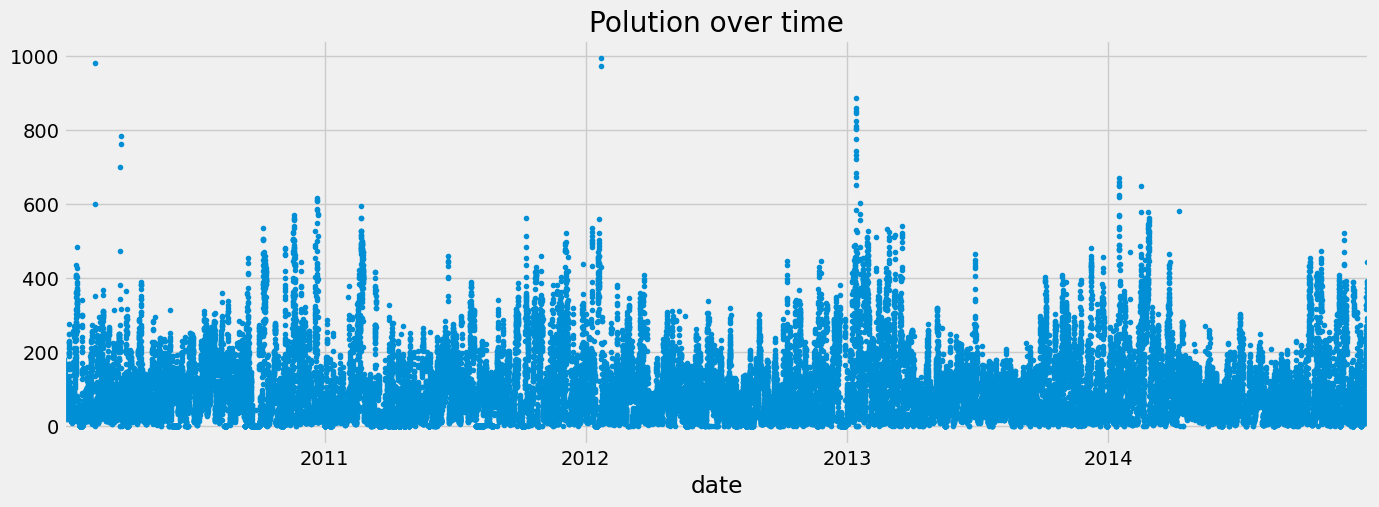

In [21]:
df["pollution"].plot(style=".", figsize=(15, 5), color=color_pal[0], title="Polution over time")

### 3. Делење на податочното множество за тренинг, тест и валидација

In [22]:
train = df.loc[df.index < "2013-01-01"]
val   = df.loc[(df.index >= "2013-01-01") & (df.index < "2014-01-01")]
test  = df.loc[df.index >= "2014-01-01"]


### 4. Исцртување на загадувањето

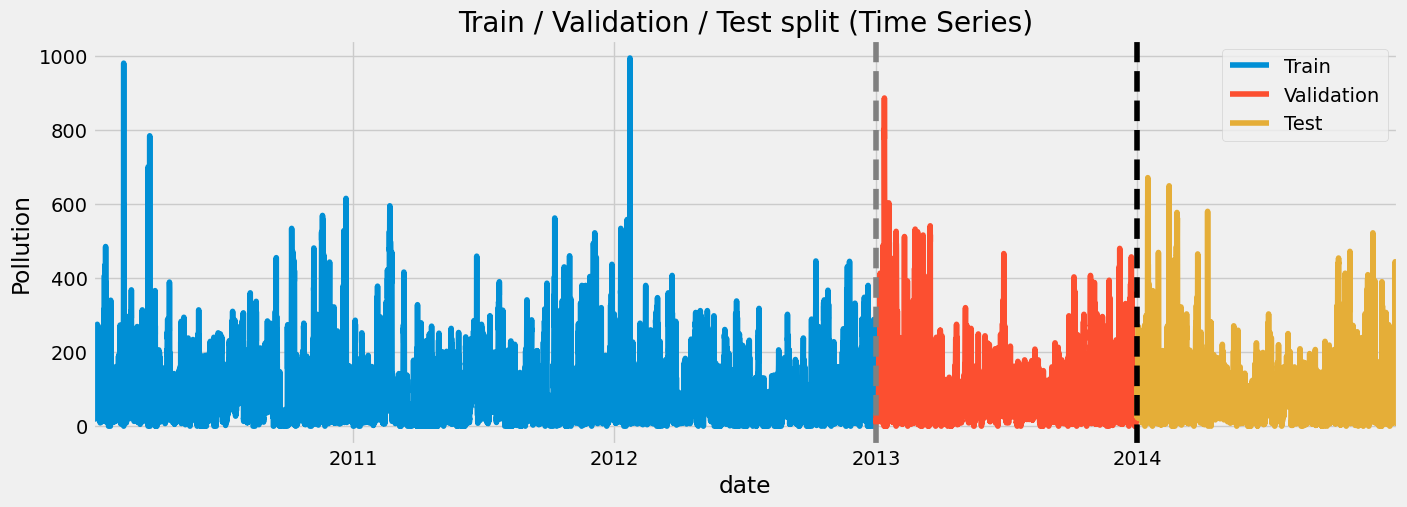

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))

train["pollution"].plot(ax=ax)
val["pollution"].plot(ax=ax)
test["pollution"].plot(ax=ax)

ax.axvline("01-01-2013", color="gray", ls="--")
ax.axvline("01-01-2014", color="black", ls="--")

ax.legend(["Train", "Validation", "Test"])
ax.set_title("Train / Validation / Test split (Time Series)")
ax.set_ylabel("Pollution")

plt.show()


<Axes: xlabel='date'>

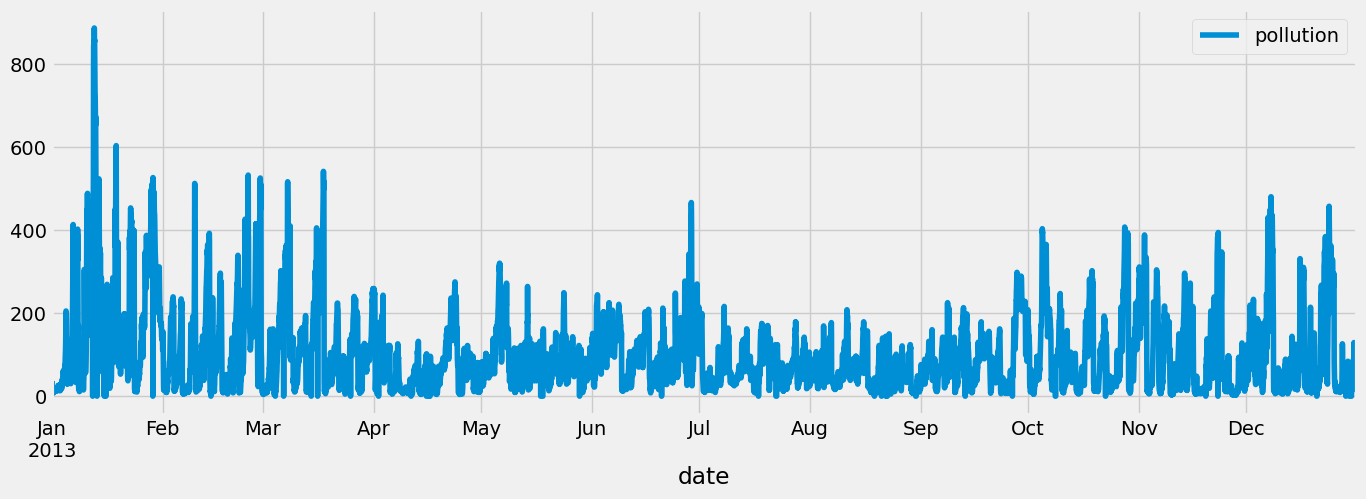

In [24]:
df.loc[
    (df.index >= "01-01-2013") & (df.index < "01-01-2014"),
    ["pollution"]
].plot(figsize=(15, 5))


<Axes: xlabel='date'>

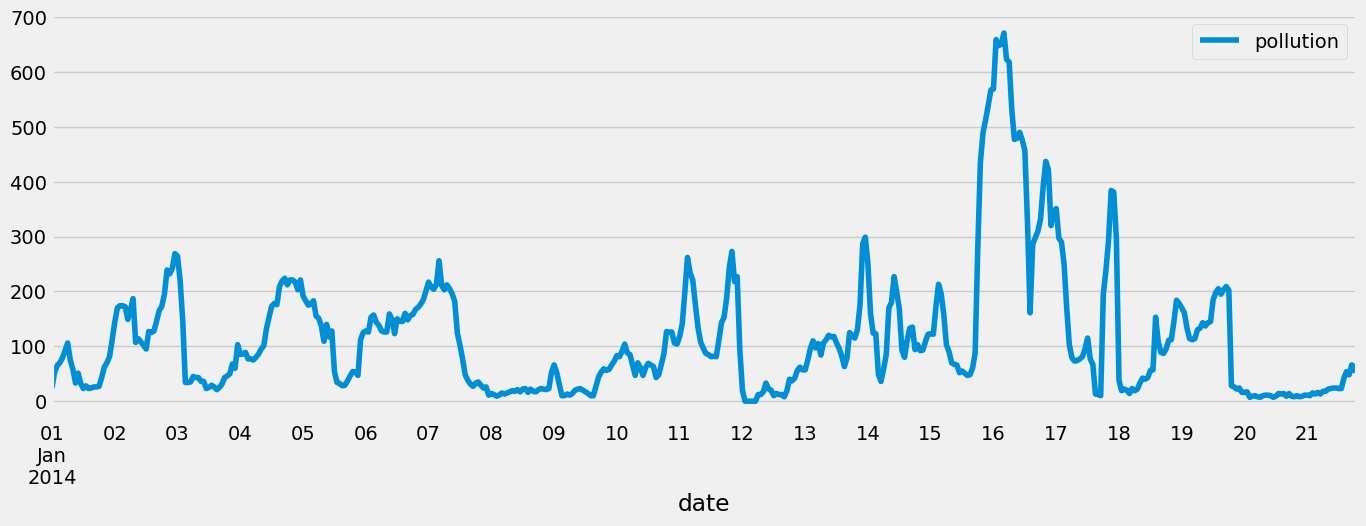

In [25]:
test.iloc[:500][["pollution"]].plot(figsize=(15, 5))


### 5. Креирање на нови карактеристики

In [26]:
def create_features(df):

    df = df.copy()

    df["hour"] = df.index.hour
    df["day"] = df.index.day
    df["month"] = df.index.month
    df["dayofweek"] = df.index.dayofweek
    df["dayofyear"] = df.index.dayofyear
    df["quarter"] = df.index.quarter
    df["weekofyear"] = df.index.isocalendar().week

    return df

df = create_features(df)

In [27]:
train = create_features(train)

features = [
    'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd',
    'snow', 'rain', 'hour', 'day', 'month',
    'dayofweek', 'dayofyear', 'quarter', 'weekofyear'
]

target = 'pollution'

train["wnd_dir"] = train["wnd_dir"].astype("category")


### 6. Визуелизација на зависноста помеѓу загадувањето и карактеристиките

<Axes: xlabel='weekofyear', ylabel='temp'>

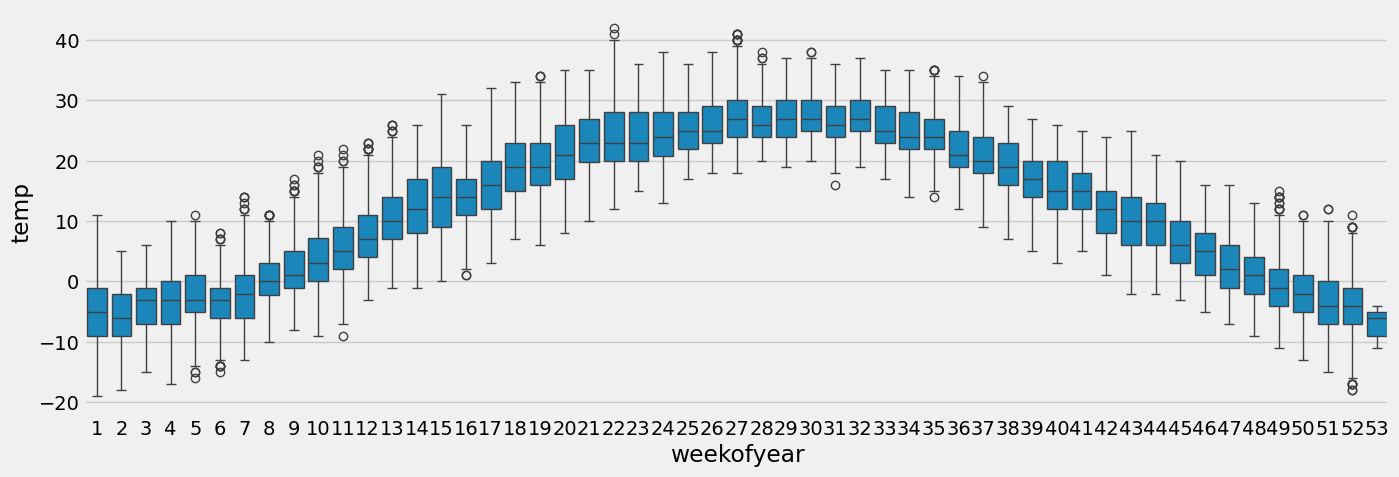

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x="weekofyear", y="temp")

<Axes: xlabel='month', ylabel='pollution'>

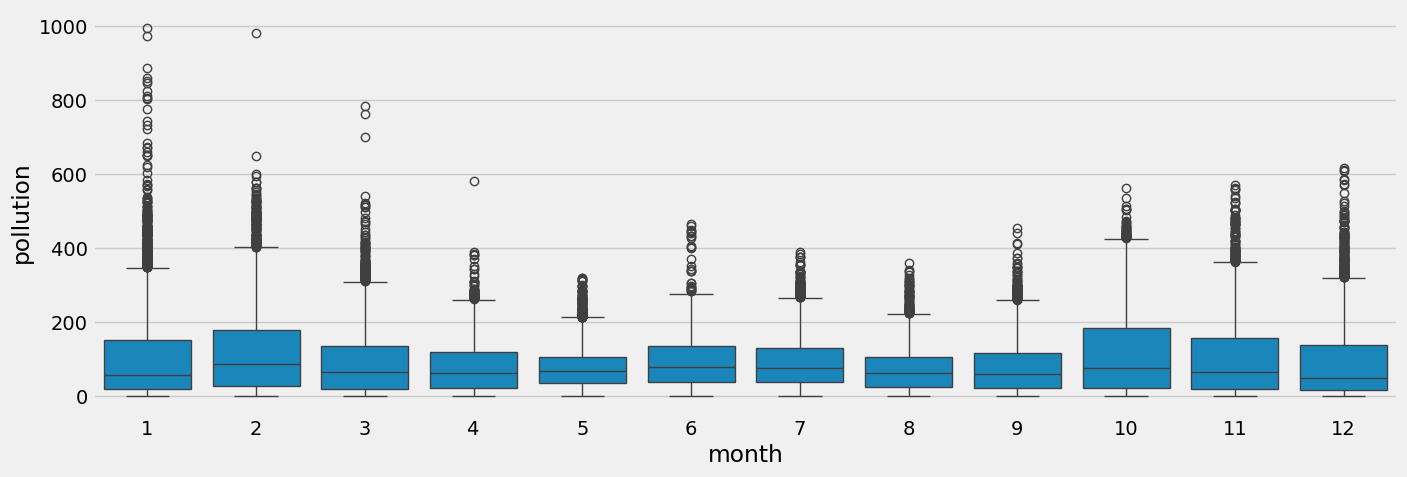

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x="month", y="pollution")

### Споредба помеѓу sliding и expanding window

In [30]:
from sklearn.metrics import mean_absolute_error
import numpy as np


In [31]:
def train_sliding_window(df, features, target, train_size, test_size):
    errors = []

    for start in range(0, len(df) - train_size - test_size, test_size):
        train_slice = df.iloc[start : start + train_size]
        test_slice  = df.iloc[start + train_size : start + train_size + test_size]

        X_train = train_slice[features]
        y_train = train_slice[target]

        X_test = test_slice[features]
        y_test = test_slice[target]

        model = xgb.XGBRegressor(
            n_estimators=50,
            learning_rate=0.1,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            enable_categorical=True,
            random_state=42
        )

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        errors.append(mean_absolute_error(y_test, preds))

    return np.mean(errors)


In [32]:
def train_expanding_window(df, features, target, initial_train_size, test_size):
    errors = []

    for end in range(initial_train_size, len(df) - test_size, test_size):
        train_slice = df.iloc[:end]
        test_slice  = df.iloc[end : end + test_size]

        X_train = train_slice[features]
        y_train = train_slice[target]

        X_test = test_slice[features]
        y_test = test_slice[target]

        model = xgb.XGBRegressor(
            n_estimators=50,
            learning_rate=0.1,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            enable_categorical=True,
            random_state=42
        )

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        errors.append(mean_absolute_error(y_test, preds))

    return np.mean(errors)


In [ ]:
sliding_mae = train_sliding_window(
    df=train,
    features=features,
    target=target,
    train_size=365,   # 1 година
    test_size=30      # 1 месец
)

expanding_mae = train_expanding_window(
    df=train,
    features=features,
    target=target,
    initial_train_size=365,
    test_size=30
)



Sliding Window MAE:   48.807
Expanding Window MAE: 48.884


In [39]:
print(f"Sliding Window MAE:   {sliding_mae:.3f}")
print(f"Expanding Window MAE: {expanding_mae:.3f}")

Sliding Window MAE:   48.807
Expanding Window MAE: 48.884


In [34]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


In [ ]:

# Feature engineering и на test
test = create_features(test)
test["wnd_dir"] = test["wnd_dir"].astype("category")


final_model = xgb.XGBRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    enable_categorical=True,
    random_state=42
)

X_train_full = train[features]
y_train_full = train[target]

final_model.fit(X_train_full, y_train_full)

X_test = test[features]
y_test = test[target]

test_preds = final_model.predict(X_test)


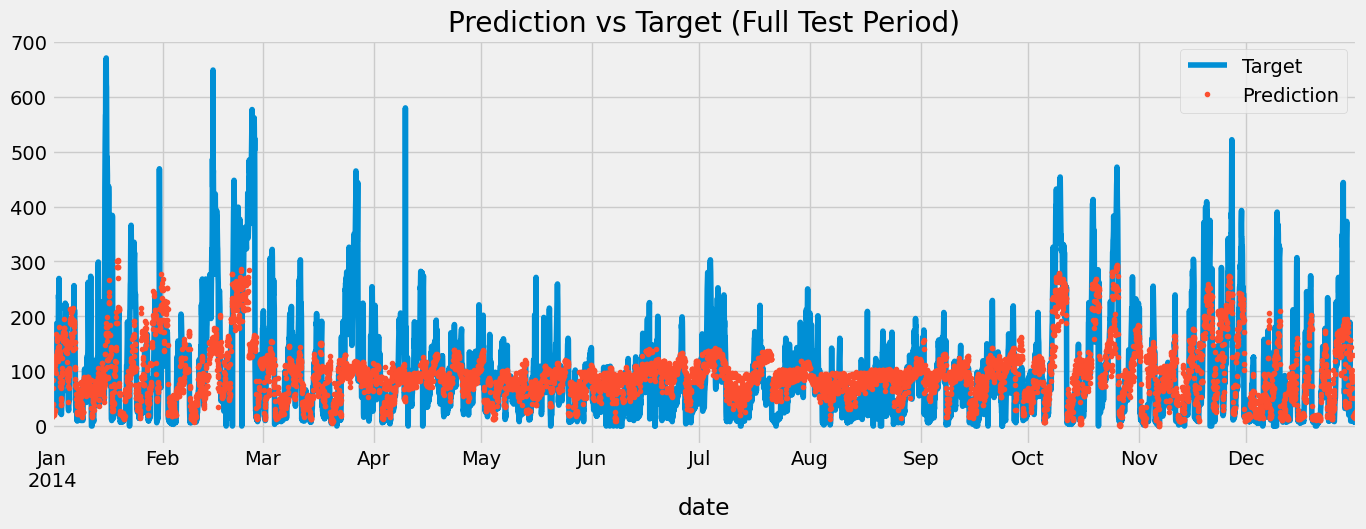

In [38]:

test["prediction"] = final_model.predict(test[features])

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
df[target].loc[df.index >= "01-01-2014"].plot(ax=ax)
test["prediction"].plot(ax=ax, style=".")
ax.set_title("Prediction vs Target (Full Test Period)")
plt.legend(["Target", "Prediction"])
plt.show()

